In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../data/Most_Frequent_Words.csv')
data.head()

,Words,Occurrences
0,vaccination,30
1,covid-19,27
2,human,22
3,vaccines,20
4,article,15


Text(0.5, 0, 'Keyword')

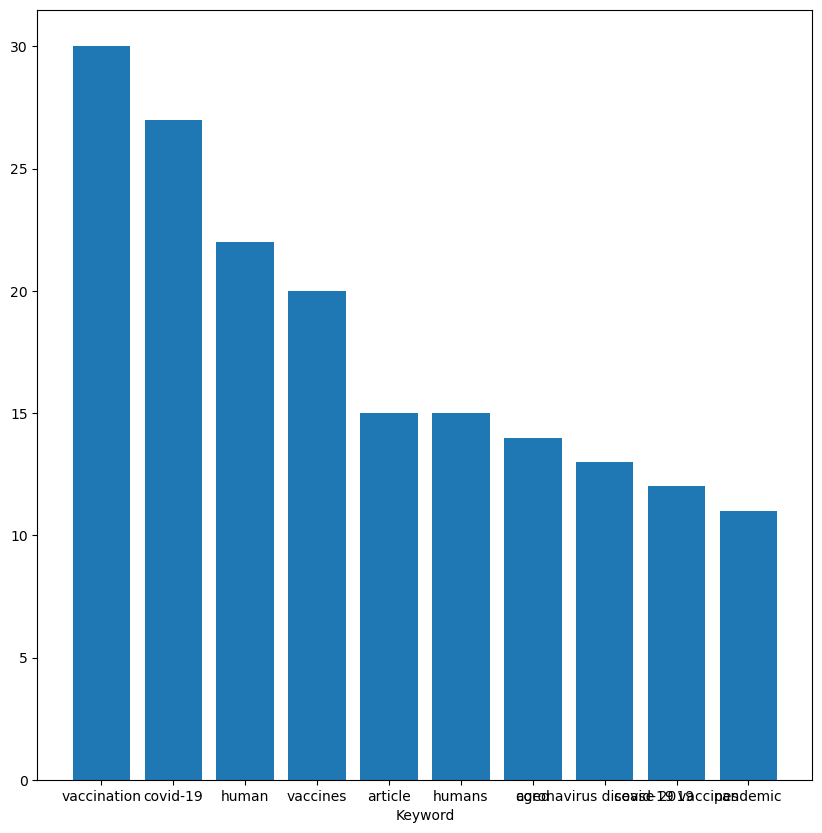

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(data["Words"], data["Occurrences"])
ax.yaxis_inverted()
ax.set_xlabel("Keyword")

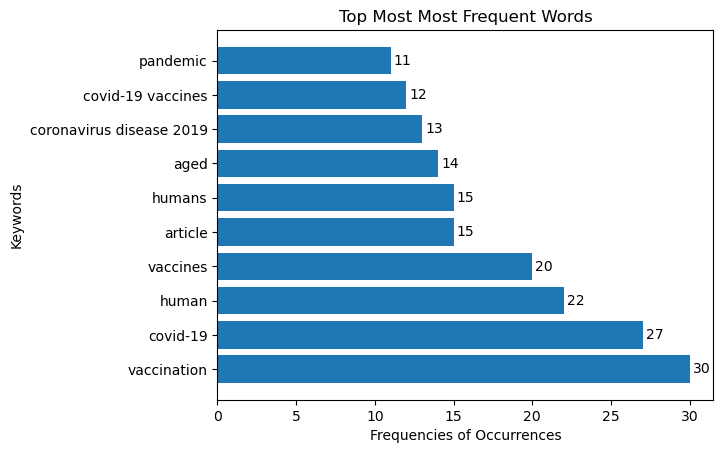

In [31]:
import matplotlib.pyplot as plt

# Define the keywords and their occurrences
keywords = ['vaccination','covid-19','human','vaccines','article','humans','aged','coronavirus disease 2019','covid-19 vaccines','pandemic']
occurrences = [30, 27, 22, 20, 15, 15, 14, 13, 12, 11]

# Create the horizontal bar chart
plt.barh(keywords, occurrences)

# Add labels to the x and y axes
plt.xlabel('Frequencies of Occurrences')
plt.ylabel('Keywords')
plt.title("Top Most Most Frequent Words")

# Display the values on the bars
for i in range(len(keywords)):
    plt.text(x = occurrences[i] + 0.2, y = keywords[i], s = occurrences[i], va='center')

# Show the plot
plt.show()



In [1]:
using DifferentialEquations, Plots, CSV, DataFrames, Dates

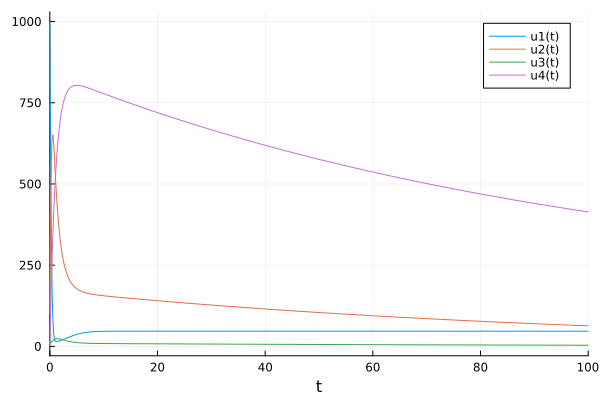

In [2]:
function SEIRS(du, u, p, t)
    S,E,I,R = u
    β, ω, γ_r, γ_i, ρ, σ = p

    du[1] = (-β * S * I) - ω*S + γ_r * R
    du[2] = (β * S * I)- σ*E - ω*E
    du[3] = (σ * ρ * E) - (γ_i * I) - (ω * I)
    du[4] = (γ_i * I) - (γ_r * R) + ω * (S+E+I)
end

p = [0.3, 0.7, 0.2,0.2, 0.5, 0.1]

init = [1000,100, 10 ,1]
tspan = (0.0, 100.0)

prob = ODEProblem(SEIRS, init, tspan, p)

sol = solve(prob, Tsit5())

plot(sol)

In [6]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

download(url, "covid_data.csv")

"covid_data.csv"

In [3]:
function data_processing(country)
    data = CSV.read("covid_data.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]

    date_strings =String.(names(data))[5:end]

    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    return country_data
end

data_processing (generic function with 1 method)

In [5]:
# date_strings =String.(names(data))[5:end]

# format = Dates.DateFormat("m/d/Y")
# dates = parse.(Date, date_strings, format) + Year(2000)

In [ ]:
ng_data = data_processing("Nigeria")

1050-element Vector{Int64}:
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      ⋮
 266283
 266283
 266283
 266283
 266283
 266283
 266283
 266283
 266283

In [8]:
df = ng_data[1:100]

100-element Vector{Int64}:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    ⋮
  873
  981
 1095
 1182
 1273
 1337
 1532
 1728
 1932

In [9]:
function SEIRS(du, u, p, t)
    S,E,I,R = u
    β, ω, γ_r, γ_i, ρ, σ = p

    du[1] = (-β * S * I) - ω*S + γ_r * R
    du[2] = (β * S * I)- σ*E - ω*E
    du[3] = (σ * ρ * E) - (γ_i * I) - (ω * I)
    du[4] = (γ_i * I) - (γ_r * R) + ω * (S+E+I)
end


SEIRS (generic function with 1 method)

In [15]:
u0 = [2*10^5; 1000; 10; 1 ]
tspan = (0.0, 100.0)
prob = ODEProblem(SEIRS, init, tspan, p)

(0.0, 100.0)

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),1.0,2.0)
    β ~ truncated(Normal(1.2,0.5),0.5,1.5)
    γ ~ truncated(Normal(3.0,0.5),2,4)
    δ ~ truncated(Normal(1.0,0.5),0.5,1.5)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

β,(start=8)
ω,(start=25.0)
γ_r,(start=10/3)
γ_i,(start= 0.01)
ρ,(start=0.01)
σ,(start=0.02)
model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.45),1000), chainscat, 1:3)

In [16]:
model_ode(p_) = ODEProblem(SEIRS, u0, tspan, p_)

model_ode (generic function with 1 method)

In [17]:
loss_objective(mp_, dat) = build_loss_objective(model_ode(mp_), Tsit5(), L2Loss(t,dat))

loss_objective (generic function with 1 method)

In [30]:
using JuMP, NLopt, HiGHS
juobj(args...) = loss_objective(args, df)(args)
jumodel = Model()
JuMP.register(jumodel, :juobj, 6, juobj, autodiff=true)
@variables jumodel begin
    β,(start=8)
    ω,(start=25.0)
    γ_r,(start=10/3)
    γ_i,(start= 0.01)
    ρ,(start=0.01)
    σ,(start=0.02)
end
@NLobjective(jumodel, Min, juobj(β, ω, γ_r, γ_i, ρ, σ))
setsolver(jumodel, NLoptSolver(algorithm=:LD_MMA))

UndefVarError: UndefVarError: setsolver not defined

In [29]:
sol = JuMP.solve(jumodel)
best_mp = getvalue.(getindex.((jumodel,), Symbol.(jumodel.colNames)))

UndefVarError: UndefVarError: solve not defined

In [14]:
using DataFrames
using Dates
using Plots
using CSV

# donwload the data:
url_confirmed_cases= "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

download(url_confirmed_cases, "../data/confirmed_cases_global.csv");
download(url_death, "../data/death_global.csv");
download(url_recovered, "../data/recovered_global.csv");

# read, clean and view the data:
data_confirmed_cases = CSV.read("../data/confirmed_cases_global.csv", DataFrame)
data_death = CSV.read("../data/death_global.csv", DataFrame)
data_recovered = CSV.read("../data/recovered_global.csv", DataFrame)

rename!(data_recovered, 1 => "province", 2 => "country")
rename!(data_death, 1 => "state", 2 => "country")
rename!(data_confirmed_cases, 1 => "state", 2 => "country")

data_us_confirmed= data_confirmed_cases[data_confirmed_cases.country .== "US",:]
data_us_death = data_death[data_death.country .== "US", :] 
data_us_recovered = data_recovered[data_recovered.country .== "US", :]
date_strings = String.(names(data_confirmed_cases))[5:end];
format = Dates.DateFormat("m/d/Y");
dates = parse.(Date, date_strings, format) .+ Year(2000);

# countries = collect(data[:, 2])
# row = findfirst(countries .== country)
# data_row = data[row, :]
# country_data = [i for i in values(data_row[5:end])]

# plot the data on graph: 
p = plot(title="US COVID-19", ylabel = "US population", xlabel = "date")
# us_confirmed_vec = vec(Array(data_us_confirmed[5:end]))
us_confirmed_vec = [i for i in values(data_us_confirmed[5:end])]
# us_recovered_vec = vec(Array(data_us_recovered[5:end]))
us_recovered_vec = [i for i in values(data_us_recovered[5:end])]
# us_death_vec = vec(Array(data_us_death[5:end]))
us_death_vec = [i for i in values(data_us_death[5:end])]
# us_tot_recovered_vec = vec(Array(data_us_recovered[5:end])) + vec(Array(data_us_death[5:end]))
us_tot_recovered_vec = [i for i in values(data_us_recovered[5:end])] + [i for i in values(data_us_death[5:end])]
us_total_agents = us_tot_recovered_vec + us_confirmed_vec

#building susceptible:
us_population = 329686270
us_susceptible_vec = us_population .- us_total_agents

plot!(dates, us_recovered_vec, label = "Recovered")
plot!(dates, us_confirmed_vec, label = "Infected")
plot!(dates, us_tot_recovered_vec, label = "Infected + Death")
plot!(dates, us_death_vec, label ="Death")

LoadError: MethodError: no method matching lastindex(::DataFrame)
[0mClosest candidates are:
[0m  lastindex(::Any, [91m::Any[39m) at abstractarray.jl:379
[0m  lastindex([91m::Union{ArrayInterfaceCore.BidiagonalIndex, ArrayInterfaceCore.TridiagonalIndex}[39m) at C:\Users\olarinoyem\.julia\packages\ArrayInterfaceCore\cV17d\src\ArrayInterfaceCore.jl:655
[0m  lastindex([91m::Union{Tables.AbstractColumns, Tables.AbstractRow}[39m) at C:\Users\olarinoyem\.julia\packages\Tables\T7rHm\src\Tables.jl:183
[0m  ...